In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import RFE
from sklearn import datasets, cluster
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import FastICA 
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Examination


A quick examination of the data set is performed


In [4]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [5]:
df.tail()


,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


I just performed a quixk check in all the categorical columns to get a feel for the ratio of data representation

In [6]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [7]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [8]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [9]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

Quick check for missing values but doesnt appear to be any

In [10]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


`Children` has a min value of 0. However this could be very possible.

Other categories attributes look good with no ovbious outlires. Maybe in `insurance_cost`

In [11]:
df[df.children == 0]

,age,gender,bmi,children,smoker,region,insurance_cost
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
4,18,female,35.625,0,no,northeast,2211.13075
6,18,female,30.115,0,no,northeast,21344.84670
7,18,male,23.750,0,no,northeast,1705.62450
...,...,...,...,...,...,...,...
1331,64,female,39.700,0,no,southwest,14319.03100
1332,64,female,35.970,0,no,southeast,14313.84630
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790


In [12]:
df[df.insurance_cost > 10000].count()

age               626
gender            626
bmi               626
children          626
smoker            626
region            626
insurance_cost    626
dtype: int64

We can see that nearly over half of the dataset have an `insurance_cost` of over 10000

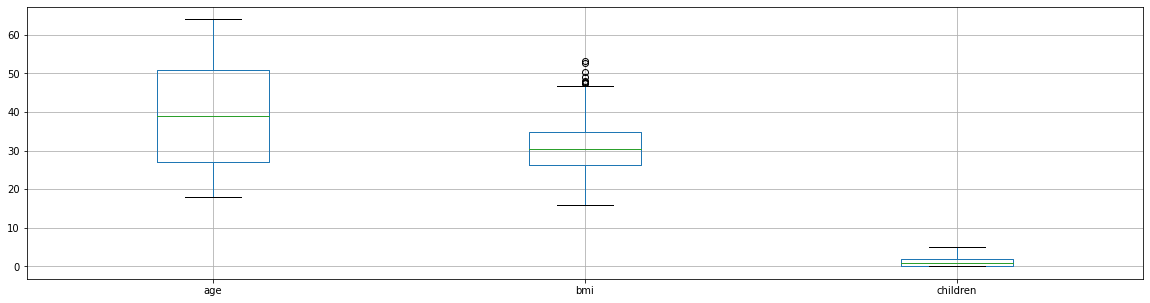

In [13]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

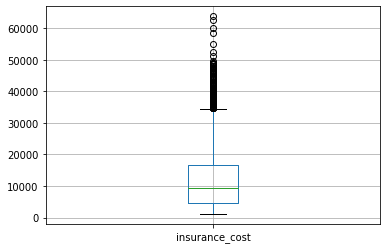

In [14]:
df.boxplot(column=['insurance_cost'])

In [15]:
df[df.insurance_cost > 34000].count()

age               144
gender            144
bmi               144
children          144
smoker            144
region            144
insurance_cost    144
dtype: int64

We have a lot of outliers when it comes to the insurance cost. around 144. However all these values are acceptable

In [16]:
df = pd.get_dummies(df, columns=['region','smoker','gender'], 
                        #dummy_na=True, 
                        drop_first=True)

In [17]:
df.head()

,age,bmi,children,insurance_cost,region_northwest,region_southeast,region_southwest,smoker_yes,gender_male
0,18,33.770,1,1725.55230,0,1,0,0,1
1,18,34.100,0,1137.01100,0,1,0,0,1
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [18]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [19]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
X.size

10704

In [21]:
y.size

1338

# Random Forest

In [22]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [23]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
LINKAGE = ['ward', 'complete', 'average', 'single']
AFFINITY = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
        {
        'reduce_dim': [LocallyLinearEmbedding(n_components=10)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
       
            {
        'reduce_dim': [FastICA(n_components=3, random_state=12) ],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [cluster.FeatureAgglomeration(n_clusters=32)],
        'reduce_dim__linkage': LINKAGE,
        'reduce_dim__affinity': AFFINITY
    },
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.858:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=11, step=1, verbose=0), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


# Linear Regression

In [24]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [25]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
LINKAGE = ['ward', 'complete', 'average', 'single']
AFFINITY = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [cluster.FeatureAgglomeration(n_clusters=32)],
        'reduce_dim__linkage': LINKAGE,
        'reduce_dim__affinity': AFFINITY
    },
      

]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.742:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                  gamma='auto', kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=6, step=1, verbose=0), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


# KNN

In [26]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', KNeighborsRegressor())])

In [27]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
LINKAGE = ['ward', 'complete', 'average', 'single']
AFFINITY = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']
N_NEIGHBORS = [3, 4, 5, 6, 7]
WEIGHTS = ['uniform', 'distance']
ALGORITHM = ['auto', 'ball_tree', 'kd_tree', 'brute']
P = [1, 2, 3]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': N_NEIGHBORS,
        'regresson__weights': WEIGHTS,
        'regresson__algorithm': ALGORITHM,
        'regresson__p': P
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': N_NEIGHBORS,
        'regresson__weights': WEIGHTS,
        'regresson__algorithm': ALGORITHM,
        'regresson__p': P
    },

]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.822:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=6, step=1, verbose=0), 'reduce_dim__n_features_to_select': 6, 'regresson__algorithm': 'brute', 'regresson__n_neighbors': 7, 'regresson__p': 3, 'regresson__weights': 'distance'}


# Compare Models

In [28]:

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [29]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNN_mse, KNN_mae, KNN_r2 = evaluate_model(X_test, y_test, KNN_best_model)

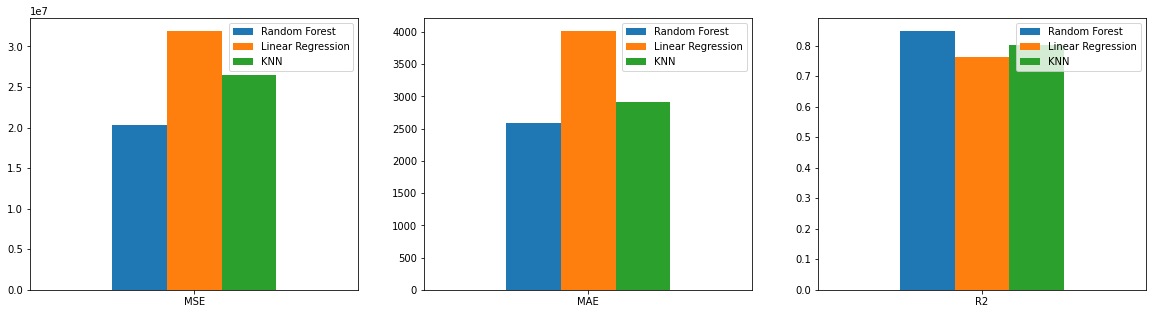

In [30]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse,'KNN':KNN_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae,'KNN':KNN_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2,'KNN': KNN_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

From running our data through the models we can see that the RF is best suited due to its low MSE and MAE score along with its high R2 score. KNN is mid way between RF and LR but still does not outperform RF in nay area. However LR performs the works in all areas.

Random Forest will be our chosen regressor

RF had a score of: 0.858
KNN had a score of:0.822
LR had a score of: 0.742


# Train the Final Model

The regressor I will train the entire dataset with is GradientBoostingRegressor as it has the best performance of the new regressors implemented.

In [31]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model = pipe.fit(X, y)

The final model can now be exported and saved for further use.

In [32]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# files.download('final_model.sav')